# Adsorption and Desorption of CO-Pd with Pyomo

Necessary imports

In [237]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.dae import *
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

Read in Data

In [238]:
# Area, Extinction Coefficient, Expected Coverage
area_data = scipy.io.loadmat('../DATA/areas.mat')
eps_data = scipy.io.loadmat('../DATA/epsilons.mat')
cov_eq_data = scipy.io.loadmat('../DATA/expected_coverage.mat')

In [239]:
# View headers
print(area_data.keys())
print(eps_data.keys())
print(cov_eq_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'area', 'area_mat', 'time_area'])
dict_keys(['__header__', '__version__', '__globals__', 'epsilon_exp', 'epsilon_sat', 'tp_idx', 'wv_split'])
dict_keys(['__header__', '__version__', '__globals__', 'cov_sat'])


In [240]:
# Areas and time variables
area = np.array(area_data['area'][0])
time = np.array(area_data['time_area'][0])

# Expected coverage at equilibrium
cov_eq = np.array(cov_eq_data['cov_sat'][0])

# Epsilong for low regions and epsilon for saturation regions
eps_low = np.array(eps_data['epsilon_exp'][0])
eps_eq = np.array(eps_data['epsilon_sat'][0])

# Index when pressure is turned off
tp_idx = np.array(eps_data['tp_idx'][0])

Specify constant parameters and labels

In [241]:
# Number of temperature data sets
N = len(area)

# List of labels
temperatures = ['450', '460', '470', '475', '480', '490']

# Constants
P = 0.001  # Pressure of CO in the gas phase

# Measurement resolution
dt = 0.067

# Specify N distinguishing colors for plotting
colors = [
    (1.0, 0.498, 0.0),    # Orange
    (1.0, 0.749, 0.0),    # Light Orange
    (0.7, 0.5, 0),        # Dark Yellow
    (0.6, 0.7, 1.0),      # Light Blue
    (0.4, 0.4, 1.0),      # Medium Blue
    (0.0, 0.0, 1.0)       # Blue
]

# Estimated from prior literature and visual inspection in the latter figure
cut_off = 0.29

# Number of regions
R = 4

Obtain the coverage deterministically through the area for each temperature based on the weighting assumption of the extinction coefficient. In contrast, in our proposed approach we model this relationship probabilistically.

In [242]:
# Get coverage from area deterministically
cov = []
for n in range(N):
    A = area[n]
    w = A/max(A)
    eps_val = w*eps_eq[n] + (1-w)*eps_low[n]
    cov.append( (A/eps_val)[0])

Visualize Coverage Data - Note that because it is obtained deterministically through the area with noise, some values are below $0$.

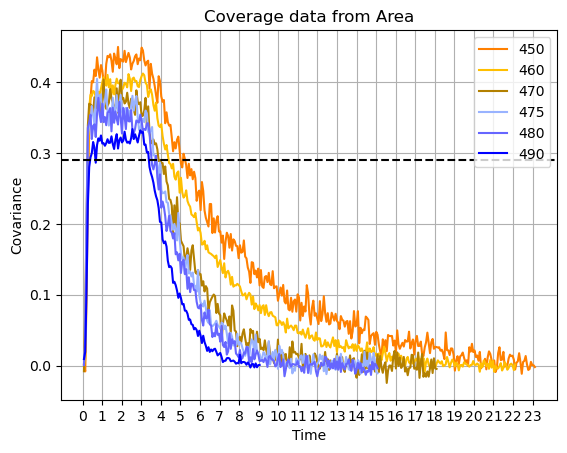

In [243]:
# Create a new figure
plt.figure()

# Plot coverage for all temperatures in one figure
for n in range(N):
    plt.plot(time[n], cov[n], color = colors[n])  # Plot the n-th pair with a label

plt.axhline(y=cut_off, color='black', linestyle='--')

# Formatting
plt.xlabel('Time') 
plt.ylabel('Covariance')  
plt.title('Coverage data from Area') 
plt.legend(temperatures)  
plt.grid(True)
plt.xticks(range(0, int(max(time[0])) + 1))

# Show the plot
plt.show()

### Pyomo Dynamic Optimization implementation

In [244]:
# With visual inspection in the above figure, we estimate the R3 to R4 split with the following time stamps for each temperature 
time_cut_off = np.array([5.3, 4.3, 3.8, 3.6, 3.5, 3.3])
time_cut_off = time_cut_off.tolist()

# Number of points in R1
idx_R1 = 6

# The 0 in index position 3 and 4 are place holders for the regions split R3 to R4, and for duration of experiment of temperature n
time_region_split = [dt, dt*6, dt*tp_idx, 0, 0]

In [245]:
# Function for the solver - will be applied to R14 and R23 separately
def apply_pyomo_solver(timejoint, covjoint, idx_R1, dt, P, time1, cov1, time2, cov2):

    cov_joint = []

    # Create the model
    model = ConcreteModel()

    # Define a discrete set for time points
    model.t = Set(initialize = timejoint)

    # Define the coverage variable, indexed by the discrete set
    model.coverage = Var(model.t, bounds=(0, 0.5))

    # Parameters to optimize: k1 and k2
    model.k1 = Var(bounds=(0, None), initialize=0.1)  # Desorption rate constant
    model.k2 = Var(bounds=(0, None), initialize=0.05)  # Adsorption rate constant

    # Define the Proposed Models
    def coverage_difference_rule(m, t):
        # Time jumps
        previous_time = t - dt 
        if previous_time in m.t:
            if previous_time > dt*idx_R1:
                return m.coverage[t] == m.coverage[previous_time] -(m.k1 * m.coverage[previous_time]) * (t - previous_time)
            else:
                return m.coverage[t] == m.coverage[previous_time] + (m.k2 * P * (0.5 - m.coverage[previous_time]) - m.k1 * m.coverage[previous_time]) * (t - previous_time)
        else:
            # because our first time data point starts with dt not 0
            return Constraint.Skip
    model.coverage_eq = Constraint(model.t, rule=coverage_difference_rule)

    # Initial and boundary condition
    model.coverage[time1[0]].fix(max(cov1[0],0))
    model.coverage[time1[-1]].fix(cov1[-1])
    model.coverage[time2[0]].fix(cov2[0])
    model.coverage[time2[-1]].fix(max(cov2[-1],0))
    

    # Define least squares loss function
    def fit_coverage_rule(m):
        # (Fitted - Data)^2
        return sum((m.coverage[t] - covjoint[i])**2 for i, t in enumerate(m.t))  
    
    # Fit the model to the observed data
    model.obj = Objective(rule=fit_coverage_rule, sense=minimize)

    # Solve the model
    solver = SolverFactory('ipopt')
    solver.solve(model, tee=False)

    # Store the fitted results of the new region
    cov_joint = [model.coverage[t]() for t in model.t]

    # Store the estimated rate constants per region
    k_des = model.k1.value
    k_ads = model.k2.value

    return [k_ads, k_des, cov_joint, timejoint]

### REGIONS 1 and 4

In [246]:
# Region 1 and 4

# For fitted coverage
covR1 = []
covR4 = []

timeR1 = []
timeR4 = []

k_ads_R14 = []
k_des_R14 = []

# Joint 
cov_R14 = []
time_R14 = []


# Get data
for n in range(N):
    # Complete splitting points
    indices = [i for i,t in enumerate(time[n]) if t < time_cut_off[n]]

    #  Extract and Concatenate data for R1 and R4
    timeR1.append([i*dt for i in range(0,idx_R1)])
    timeR4.append([i*dt for i in range(indices[-1]-1,len(time[n]))])

    # Separate R1 and R4 coverage data
    covR1.append(list(cov[n][:idx_R1]))
    covR4.append(list(cov[n][indices[-1]-1:len(cov[n])+1]))

    # Concatenated coverage data R1 and R4
    covR14 = list(covR1[n]) + list(covR4[n])
    timeR14 = timeR1[n] + timeR4[n]

    # Apply Solver
    k_ads14, k_des14, cov14, time14 = apply_pyomo_solver(timeR14, covR14, idx_R1, dt, P, timeR1[n], covR1[n], timeR4[n], covR4[n])

    # Store rate constants for each temp
    k_ads_R14.append(k_ads14)
    k_des_R14.append(k_des14)

    # Store fitted cov and time for plotting
    cov_R14.append(cov14)
    time_R14.append(time14)




### REGIONS 2 and 3

In [247]:
# Region 2 and 3

# For fitted coverage
timeR2 = []
timeR3 = []

covR2 = []
covR3 = []

# Joint
time_R23 = []
cov_R23 = []

k_ads_R23 = []
k_des_R23 = []

# Get data
for n in range(N):
    # Complete splitting points
    indices = [i for i,t in enumerate(time[n]) if t < time_cut_off[n]]

    #  Extract and Concatenate data for R2 and R3
    timeR2.append([i*dt for i in range(idx_R1,tp_idx[0])])
    timeR3.append([i*dt for i in range(tp_idx[0], indices[-1])])

    # Separate R1 and R4 coverage data
    covR2.append(list(cov[n][idx_R1:tp_idx[0]]))
    covR3.append(list(cov[n][tp_idx[0] : indices[-1]]))

    # Concatenated coverage data R2 and R3
    covR23 = covR2[n] + covR3[n]
    timeR23 = timeR2[n] + timeR3[n]

    # Apply Solver
    k_ads23, k_des23, cov23, time23 = apply_pyomo_solver(timeR23, covR23, idx_R1, dt, P, timeR2[n], covR2[n], timeR3[n], covR3[n])

    # Store rate constants
    k_ads_R23.append(k_ads23)
    k_des_R23.append(k_des23)

    # Store coverage and time for plotting
    cov_R23.append(cov23)
    time_R23.append(timeR23)
    


### Reorganize for easy plotting

In [248]:
time_plot = []
cov_plot = []
for n in range(N):
    time_plot.append(timeR1[n] + time_R23[n] + timeR4[n])
    cov_plot.append(covR1[n] + cov_R23[n] + covR4[n])

#### Visualize Results

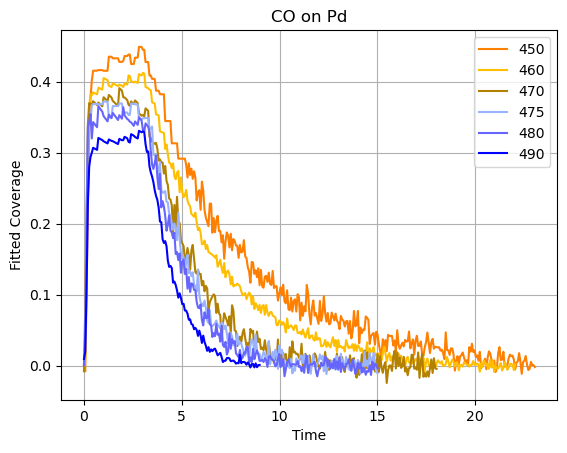

In [249]:
# Fitted coverages for all temperatures
plt.figure()

for n in range(N):
    plt.plot(time_plot[n], cov_plot[n], color = colors[n])

# Labels
plt.xlabel('Time')
plt.ylabel('Fitted Coverage')
plt.title('CO on Pd')
plt.grid(True)
plt.legend(temperatures)
plt.show()

#### Plot fitting against data

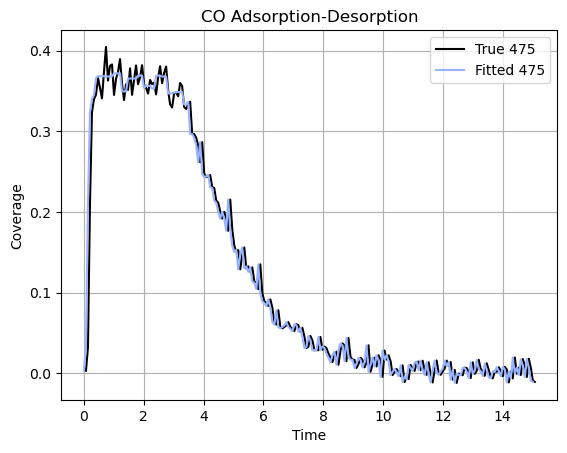

In [250]:
''' Choose temperature index
n = 0 --> 450 K
n = 1 --> 460 K
n = 2 --> 470 K
n = 3 --> 475 K
n = 4 --> 480 K
n = 5 --> 490 K
'''
n = 3

# Create figure
plt.figure()
plt.plot(time[n],cov[n], color = (0,0,0) )
plt.plot(time_plot[n], cov_plot[n], color = colors[n])

# Labels
plt.xlabel('Time')
plt.ylabel('Coverage')
plt.title('CO Adsorption-Desorption')
plt.grid(True)
plt.legend(['True ' +  temperatures[n] , 'Fitted ' + temperatures[n]])
plt.show()

In [251]:
print(f'Adsorption rate constant in Region {1}: k_ads = {k_ads_R14}')
print(f'Adsorption rate constant in Region {2}: k_ads = {k_ads_R23}')
print(f'Desorption rate constant in Regions {2} and {3}: k_des = {k_des_R23}')
print(f'Desorption rate constant in Regions {1} and {4}: k_des = {k_des_R14}')

Adsorption rate constant in Region 1: k_ads = [3649.0078913937477, 3893.0486045857406, 3877.7342242218356, 3588.95287297064, 3642.6622361046266, 2563.230731500531]
Adsorption rate constant in Region 2: k_ads = [2096.0478627808798, 621.2460416533926, 813.4185062121371, 224.90024081135064, 2098.4921103236693, 585.5858010519398]
Desorption rate constant in Regions 2 and 3: k_des = [7.075547039449037e-07, 0.03414310769325718, 0.07123780056529823, 8.921705082341948e-07, 0.10510176197067775, 0.04747918402890911]
Desorption rate constant in Regions 1 and 4: k_des = [0.023093808419430654, 0.1513758944663964, 0.4238725389309806, 0.6269647689996979, 0.48248736050745267, 0.3680619776876061]


In [252]:
k = [k_ads_R14, k_ads_R23, k_des_R14, k_des_R23]

In [253]:
table = [[f'{k[r][n]}' for r in range(4)] for n in range(6)]

# Print the table to see the result
for n in range(N):
    print(temperatures[n], 'K: Adsorption k_ads =  ', table[n][:2], '    Desorption k_des = ', table[n][2:])


450 K: Adsorption k_ads =   ['3649.0078913937477', '2096.0478627808798']     Desorption k_des =  ['0.023093808419430654', '7.075547039449037e-07']
460 K: Adsorption k_ads =   ['3893.0486045857406', '621.2460416533926']     Desorption k_des =  ['0.1513758944663964', '0.03414310769325718']
470 K: Adsorption k_ads =   ['3877.7342242218356', '813.4185062121371']     Desorption k_des =  ['0.4238725389309806', '0.07123780056529823']
475 K: Adsorption k_ads =   ['3588.95287297064', '224.90024081135064']     Desorption k_des =  ['0.6269647689996979', '8.921705082341948e-07']
480 K: Adsorption k_ads =   ['3642.6622361046266', '2098.4921103236693']     Desorption k_des =  ['0.48248736050745267', '0.10510176197067775']
490 K: Adsorption k_ads =   ['2563.230731500531', '585.5858010519398']     Desorption k_des =  ['0.3680619776876061', '0.04747918402890911']


## Activation Energy and Pre-exponential Factors

In [254]:
import numpy as np
from scipy.stats import linregress

def calculate_Ea_and_lnA(temperatures, rate_constants):

    R_constant = 0.001987204258  # Gas constant in kcal/(mol·K)

    # Convert temperatures to 1/T
    inverse_temperatures = 1 / np.array(temperatures)
    
    # Take the natural log of the rate constants
    ln_k = np.log(rate_constants)

    # Perform linear regression on ln(k) vs 1/T
    slope, intercept, r_value, p_value, std_err = linregress(inverse_temperatures, ln_k)

    # Calculate activation energy from the slope (-Ea/R)
    Ea = -slope * R_constant
    lnA = intercept


    return [Ea, lnA, std_err*R_constant]


In [255]:
temperatures_vals = np.array([450., 460., 470., 475., 480., 490.])

In [256]:
Ea = []
lnA = []

# For
for r in range(R):
    rate_constants = np.array(k[r], dtype=float)  # example rate constants

    Ea_region, lnA_region, se = calculate_Ea_and_lnA(temperatures_vals, rate_constants)

    Ea.append(Ea_region)
    lnA.append(lnA_region)


In [264]:
for r in range(R):
    print(f'R{r+1}: Activation Energy Ea =  ',Ea[r], ' and Pre-exponential factor lnA = ', lnA[r])

R1: Activation Energy Ea =   -3.1693592048051893  and Pre-exponential factor lnA =  4.771232390875932
R2: Activation Energy Ea =   -8.716663212582944  and Pre-exponential factor lnA =  -2.620430502752667
R3: Activation Energy Ea =   31.380310935206822  and Pre-exponential factor lnA =  32.113099201882775
R4: Activation Energy Ea =   85.15945318117701  and Pre-exponential factor lnA =  84.51906897771252
